<a href="https://colab.research.google.com/github/ramapriyakj/yelp/blob/master/YelpAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Integration with google drive.


In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
data_set_dir = root_dir + 'Colab Notebooks/dataset/yelp/'

Mounted at /content/gdrive


**Yelp Data Analysis**

In this project we perform sentimental analysis on yelp data set (https://www.yelp.com/dataset ).

review.json file is used to perform sentimental analysis on businesses.

Only first 200000 (positive + negative) reviews are extracted from the dataset and analysis is performed.

user ratings > 3 are positive else negative.

Final classification accuracies by different models are reported :


1.   RF - Random forest classifier
2.   DENSE - Dense feed forward network
3.   CONV - Processing with COVNET
4.   RNN - Simple recurrent neural network
5.   LSTM - Long short term memory
6.   BI-LSTM - Bi directional LSTM


Review JSON path

In [0]:
import os,sys
review_path = data_set_dir + "review.json";
if os.path.isfile(review_path):
    pass
else:
    print("Invalid file path. Please place the python file in the same folder as review.json and rerun.")
    sys.exit(0)

Required libraries

In [3]:
from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, Bidirectional, Embedding, Dropout, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.optimizers import RMSprop
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from wordcloud import STOPWORDS
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

Using TensorFlow backend.


Read json

In [4]:
max_records = 100000
x_raw = []
y_raw = []
reviews = pd.read_json(review_path,lines=True,chunksize=max_records)
pos = 0
neg = 0
for chunks in reviews:
  if len(y_raw) == max_records*2:
    break
  for index, rec in chunks.iterrows():
    y = rec["stars"]
    if pos < max_records and y > 3:            
      pos = pos + 1
      x_raw.append(rec["text"])
      y_raw.append(1)
    elif neg < max_records:
      neg = neg + 1
      x_raw.append(rec["text"])
      y_raw.append(0)
      
print("Length of data : ",len(x_raw))

Length of data :  200000


Only first 150 words are used for review (**input_shape**).

**vocab_len** is a parameter which is used to train Embedding layer whose size is equal to the number of unique words in sequences.

In [0]:
input_shape = 100
vocab_len = None

* Stop words which doesn't add much meaning to the sequences are filtered.
* Tokens are padded to same length and vectorized

In [6]:
x_text = []
for w in x_raw:
    arr = [s for s in text_to_word_sequence(w) if not s in STOPWORDS]  
    x_text.append(arr)
t = Tokenizer()
t.fit_on_texts(x_text)
vocab_len = len(t.word_index) + 1

sequences = t.texts_to_sequences(x_text)
data = pad_sequences(sequences, maxlen=input_shape)
labels = np.asarray(y_raw)

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (200000, 100)
Shape of label tensor: (200000,)


Split data into train, test and validation set.

In [7]:
x_train,x_test,y_train,y_test = train_test_split(data,labels,test_size=0.1,random_state=101)
x_train,x_val,y_train,y_val = train_test_split(x_train,y_train,test_size=0.1,random_state=102)
print('x_train:', x_train.shape)
print('y_train:', y_train.shape)
print('x_val:', x_val.shape)
print('y_val:', y_val.shape)
print('x_test:', x_test.shape)
print('y_test:', y_test.shape)

x_train: (162000, 100)
y_train: (162000,)
x_val: (18000, 100)
y_val: (18000,)
x_test: (20000, 100)
y_test: (20000,)


Function return model of specified type

* name: Name of the model 
* vocab_len : Embedding vocabulary size
* inp_shape : Input shape

In [0]:
def getModel(name,vocab_len,inp_shape):
    if name == "DENSE":
        model = Sequential()
        model.add(Dense(128, activation='relu', input_shape=(inp_shape,)))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
        return model
    elif name == "RNN":
        model = Sequential()
        model.add(Embedding(vocab_len, 32))
        model.add(SimpleRNN(32, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))
        model.add(SimpleRNN(32, dropout=0.1, recurrent_dropout=0.1))
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.1))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
        return model
    elif name == "LSTM":
        model = Sequential()
        model.add(Embedding(vocab_len, 32))
        model.add(LSTM(32, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))
        model.add(LSTM(32, dropout=0.1, recurrent_dropout=0.1))
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.1))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
        return model
    elif name == "BI-LSTM":
        model = Sequential()
        model.add(Embedding(vocab_len, 32))
        model.add(Bidirectional(LSTM(32, return_sequences=True,dropout=0.1, recurrent_dropout=0.1)))
        model.add(Bidirectional(LSTM(32, dropout=0.1, recurrent_dropout=0.1)))
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.1))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
        return model
    elif name == "CONV":
        model = Sequential()
        model.add(Embedding(vocab_len, 32))
        model.add(Conv1D(32, 7, activation='relu'))
        model.add(MaxPooling1D(5))
        model.add(Conv1D(32, 7, activation='relu'))
        model.add(GlobalMaxPooling1D())
        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer=RMSprop(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
        return model
    elif name == "RF":
        model = RandomForestClassifier(verbose=0,n_jobs=-1,random_state=136)
        return model
    

Plot accuracies

In [0]:
def plot_accuracy(model_name,history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title(model_name+' - Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

Train model and predict accuracies

Processing model :  RF


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


['54.17', '55.92', '43.35', '48.84']
Processing model :  DENSE
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 162000 samples, validate on 18000 samples
Epoch 1/5
162000/162000 [==============================] - 6s 35us/step - loss: 7.9343 - acc: 0.5052 - val_loss: 7.9977 - val_acc: 0.4984
Epoch 2/5
162000/162000 [==============================] - 5s 29us/step - loss: 7.9637 - acc: 0.5005 - val_loss: 8.0696 - val_acc: 0.4938
Epoch 3/5
162000/162000 [==============================] - 5s 28us/step - loss: 7.9595 - acc: 0.5007 - val_loss: 8.0652 - val_acc: 0.4941
Epoch 4/5
162000/162000 [==============================] - 4s 26us/step - loss: 7.8933 - acc: 0.5050 - val_loss: 7.4058 - val_acc: 0.5367
Epoch 5/5
162000/162000 [==============================] - 4s 26us/step - loss: 7.5128 - acc: 0.5311 - val_loss: 7.3845 - val_acc: 0.5384


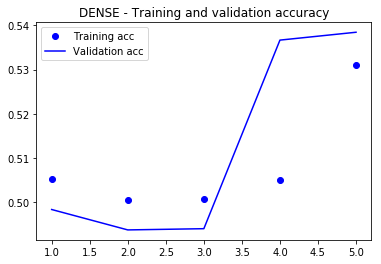

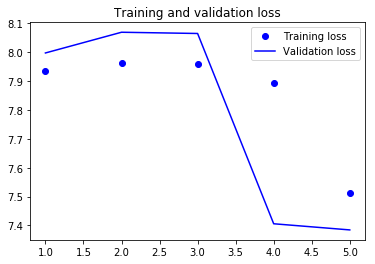

['54.37', '53.99', '64.75', '58.89']
Processing model :  CONV
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 162000 samples, validate on 18000 samples
Epoch 1/5
162000/162000 [==============================] - 10s 62us/step - loss: 0.6548 - acc: 0.5995 - val_loss: 0.5789 - val_acc: 0.6993
Epoch 2/5
162000/162000 [==============================] - 8s 48us/step - loss: 0.5386 - acc: 0.7307 - val_loss: 0.5337 - val_acc: 0.7324
Epoch 3/5
162000/162000 [==============================] - 8s 48us/step - loss: 0.5157 - acc: 0.7480 - val_loss: 0.5271 - val_acc: 0.7368
Epoch 4/5
162000/162000 [==============================] - 8s 48us/step - loss: 0.5061 - acc: 0.7541 - val_loss: 0.5240 - val_acc: 0.7397
Epoch 5/5
162000/162000 [==============================] - 8s 48us/step - loss: 0.4998 - acc: 0.7586 - val_loss: 0.5232 - val_acc: 0.7400


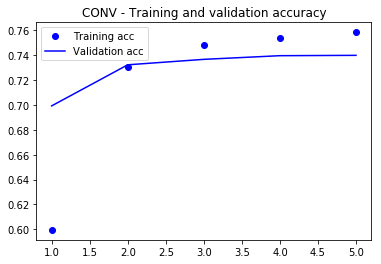

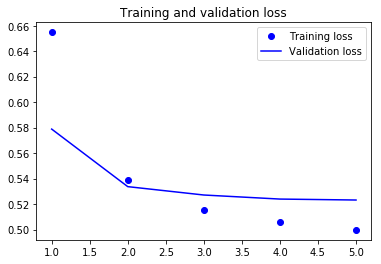

['74.38', '70.69', '84.10', '76.81']
Processing model :  RNN
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 162000 samples, validate on 18000 samples
Epoch 1/5
162000/162000 [==============================] - 104s 643us/step - loss: 0.6168 - acc: 0.6327 - val_loss: 0.5433 - val_acc: 0.7274
Epoch 2/5
162000/162000 [==============================] - 104s 643us/step - loss: 0.5356 - acc: 0.7356 - val_loss: 0.5307 - val_acc: 0.7353
Epoch 3/5
162000/162000 [==============================] - 105s 646us/step - loss: 0.5257 - acc: 0.7434 - val_loss: 0.5366 - val_acc: 0.7299
Epoch 4/5
162000/162000 [==============================] - 103s 636us/step - loss: 0.5191 - acc: 0.7480 - val_loss: 0.5335 - val_acc: 0.7411
Epoch 5/5
162000/162000 [==============================] - 106s 654us/step - loss: 0.5129 - acc: 0.7523 - val_loss: 0.5342 - val_acc: 0.7363


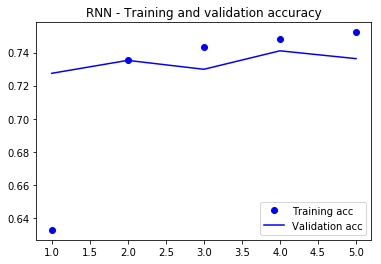

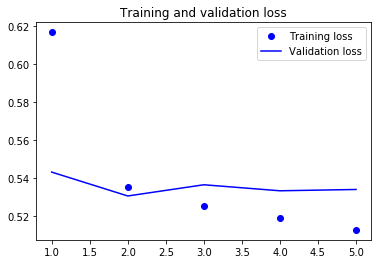

['74.02', '69.01', '88.06', '77.38']
Processing model :  LSTM
Train on 162000 samples, validate on 18000 samples
Epoch 1/5
162000/162000 [==============================] - 422s 3ms/step - loss: 0.5281 - acc: 0.7369 - val_loss: 0.5071 - val_acc: 0.7481
Epoch 2/5
162000/162000 [==============================] - 434s 3ms/step - loss: 0.4954 - acc: 0.7609 - val_loss: 0.5047 - val_acc: 0.7538
Epoch 3/5
162000/162000 [==============================] - 424s 3ms/step - loss: 0.4843 - acc: 0.7687 - val_loss: 0.5034 - val_acc: 0.7529
Epoch 4/5
162000/162000 [==============================] - 417s 3ms/step - loss: 0.4742 - acc: 0.7746 - val_loss: 0.5097 - val_acc: 0.7460
Epoch 5/5
162000/162000 [==============================] - 418s 3ms/step - loss: 0.4661 - acc: 0.7809 - val_loss: 0.5093 - val_acc: 0.7477


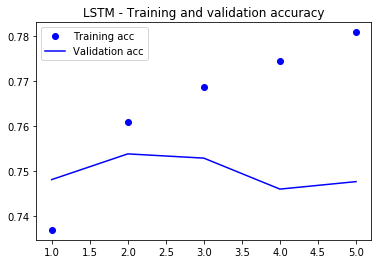

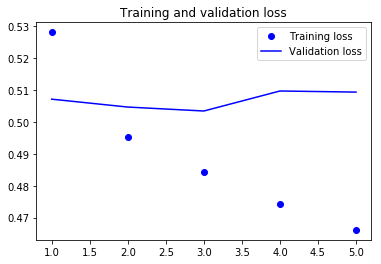

['75.29', '71.25', '85.54', '77.75']
Processing model :  BI-LSTM
Train on 162000 samples, validate on 18000 samples
Epoch 1/5
162000/162000 [==============================] - 837s 5ms/step - loss: 0.5248 - acc: 0.7378 - val_loss: 0.5048 - val_acc: 0.7526
Epoch 2/5
162000/162000 [==============================] - 831s 5ms/step - loss: 0.4938 - acc: 0.7625 - val_loss: 0.5061 - val_acc: 0.7504
Epoch 3/5
162000/162000 [==============================] - 830s 5ms/step - loss: 0.4845 - acc: 0.7682 - val_loss: 0.5026 - val_acc: 0.7542
Epoch 4/5
162000/162000 [==============================] - 829s 5ms/step - loss: 0.4749 - acc: 0.7744 - val_loss: 0.5054 - val_acc: 0.7538
Epoch 5/5
162000/162000 [==============================] - 834s 5ms/step - loss: 0.4665 - acc: 0.7804 - val_loss: 0.5038 - val_acc: 0.7518


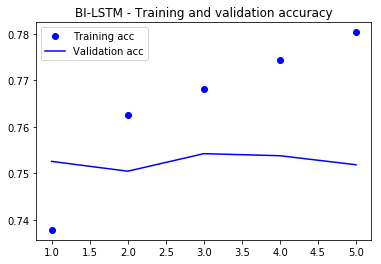

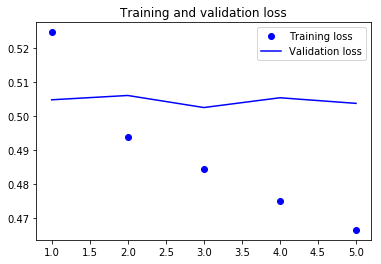

['75.59', '69.73', '91.24', '79.05']


In [10]:
model_list = ["RF","DENSE","CONV","RNN","LSTM","BI-LSTM"]
accuracy_report = []
for name in model_list:
    print("Processing model : ",name);
    model = getModel(name,vocab_len,input_shape)
    y_pred = None
    
    if name == "DENSE" or name == "RNN" or name == "LSTM" or name == "BI-LSTM" or name == "CONV":
        history = model.fit(x_train, y_train,epochs=5,batch_size=128,validation_data=(x_val, y_val)) 
        plot_accuracy(name,history)
        y_pred = model.predict_classes(x_test)        
    elif name == "RF":
        model.fit(x_train,y_train)
        y_pred = model.predict(x_test)
    accuracy_report.append([
        format(accuracy_score(y_test,y_pred)*100,'.2f'),
        format(precision_score(y_test,y_pred)*100,'.2f'),
        format(recall_score(y_test,y_pred)*100,'.2f'),
        format(f1_score(y_test,y_pred)*100,'.2f')])
    print(accuracy_report[-1])

In [11]:
from prettytable import PrettyTable
print("Testing results:")
t = PrettyTable(['Model','Acuracy','Precision','Recall','F1-Score'])
for a,b in zip(model_list,accuracy_report):
    t.add_row([a,b[0],b[1],b[2],b[3]])
print(t)

Testing results:
+---------+---------+-----------+--------+----------+
|  Model  | Acuracy | Precision | Recall | F1-Score |
+---------+---------+-----------+--------+----------+
|    RF   |  54.17  |   55.92   | 43.35  |  48.84   |
|  DENSE  |  54.37  |   53.99   | 64.75  |  58.89   |
|   CONV  |  74.38  |   70.69   | 84.10  |  76.81   |
|   RNN   |  74.02  |   69.01   | 88.06  |  77.38   |
|   LSTM  |  75.29  |   71.25   | 85.54  |  77.75   |
| BI-LSTM |  75.59  |   69.73   | 91.24  |  79.05   |
+---------+---------+-----------+--------+----------+
